In [1]:
import stockait as sai
import pandas as pd

This file provides an example of using the stockait package to experiment with the same preprocessed data to see which models perform best and how each trader yields.

--------

# 1. Load Data

⭐ Skip the process of generating data and proceed with the pre-processed and saved data file in the `00.demo.ipynb` file.

In [2]:
df_time_series = pd.read_parquet("../../../../cha0716/time_series_0305.parquet")
df_time_series_scaled = pd.read_parquet("../../../../cha0716/time_series_scaled_0305.parquet")

df_time_series = df_time_series[~(df_time_series["Code"].isin(["33626K", "33637k", '33637K']))]
df_time_series_scaled = df_time_series_scaled[~(df_time_series_scaled["Code"].isin(["33626K", "33637k", '33637K']))]

df_time_series['Code'] = df_time_series['Code'].astype(str).str.zfill(6)
df_time_series_scaled['Code'] = df_time_series_scaled['Code'].astype(str).str.zfill(6)

The dataset used is a 10-day time series dataset standardized in the 'div-close' method from 2016 to 2021.

In [3]:
data = df_time_series # Data Before Scaling
data_scaled = df_time_series_scaled # Data After Scaling

# train, test dataset split
train_data = data[(data['Date'] >= '2017-01-01') & (data['Date'] <= '2020-12-31')]
test_data = data[(data['Date'] >= '2021-01-01') & (data['Date'] <= '2021-12-31')]

# train, test dataset split (scaled) 
train_data_scaled = data_scaled[(data_scaled['Date'] >= '2017-01-01') & (data_scaled['Date'] <= '2020-12-31')]
test_data_scaled = data_scaled[(data_scaled['Date'] >= '2021-01-01') & (data_scaled['Date'] <= '2021-12-31')]

print(train_data.shape, test_data.shape)
print(train_data_scaled.shape, test_data_scaled.shape)

(828290, 483) (217159, 483)
(828290, 483) (217159, 483)


We set the learning dataset from 2017 to 2020 and the test dataset from 2021.

# 2. Trader Definition

  Next, define a trader. In this file, we will use the LightGBM, XGBoost, RandomForest, and LSTM models defined in the `01.trader_definition.ipynb` file.

In [4]:
lst_trader = [] 

### 1) LightGBM 

In [5]:
from lightgbm import LGBMClassifier

# conditional_buyer: Object that determines acquisition based on data filtering conditions 
b1_lg = sai.ConditionalBuyer()

def sampling1(df): # Create a conditional function
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) # Remove exceptions that exceed upper and lower limits
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 # condition 1: Transaction amount of more than 1 billion won 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) # condition 2: Today's stock price change rate is more than 5%
    condition = condition1 & condition2 & condition3
    return condition

b1_lg.condition = sampling1  # Define the condition function directly (sampling1) and store it in the condition property 


# machinelearning_buyer: Object that determines acquisition by machine learning model
b2_lg = sai.MachinelearningBuyer()

# Save user-defined models to algorithm properties
scale_pos_weight = round(72/28 , 2)
params = {  'random_state' : 42,
            'scale_pos_weight' : scale_pos_weight,
            'learning_rate' : 0.1, 
            'num_iterations' : 1000,
            'max_depth' : 4,
            'n_jobs' : 30,
            'boost_from_average' : False,
            'objective' : 'binary' }

b2_lg.algorithm =  LGBMClassifier( **params )


# SubSeller: Object that determines selling all of the following days
sell_all = sai.SubSeller() 


# Trader Object   
t1 = sai.Trader()
t1.name = 'saiLightGBM' # Trader's name
t1.label = 'class&0.02' # Set the Trader dependent variable (do not set if it is regression analysis) 
t1.buyer = sai.Buyer([b1_lg, b2_lg]) # [ conditional buyer, machinelearning buyer ] 
t1.seller = sai.Seller(sell_all)

lst_trader.append(t1)

### 2) XGBoost 

In [6]:
from xgboost import XGBClassifier

b1_xgb = sai.ConditionalBuyer() 

def sampling2(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_xgb.condition = sampling2


b2_xgb = sai.MachinelearningBuyer()  

scale_pos_weight = round(72/28 , 2)
b2_xgb.algorithm = XGBClassifier(random_state = 42,
                   n_jobs=30,
                   scale_pos_weight=scale_pos_weight,
                   learning_rate=0.1,
                   max_depth=4,
                   n_estimators=1000,
                   )  

sell_all = sai.SubSeller()


t2 = sai.Trader()
t2.name = 'saiXGboost' 
t2.label = 'class&0.02' 
t2.buyer = sai.Buyer([b1_xgb, b2_xgb])
t2.seller = sai.Seller(sell_all) 

lst_trader.append(t2) 

### 3) RandomForest 

In [7]:
from sklearn.ensemble import RandomForestClassifier

b1_rf = sai.ConditionalBuyer()

def sampling3(df):  
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_rf.condition = sampling3


b2_rf = sai.MachinelearningBuyer()  

b2_rf.algorithm = RandomForestClassifier() 


sell_all = sai.SubSeller() 


t3 = sai.Trader()
t3.name = 'saiRandomForest'  
t3.label = 'class&0.02' 
t3.buyer = sai.Buyer([b1_rf, b2_rf]) 
t3.seller = sai.Seller(sell_all)

lst_trader.append(t3) 

### 4) LSTM 

In [8]:
from tensorflow import keras
import numpy as np

b1_ls = sai.ConditionalBuyer()

def sampling4(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_ls.condition = sampling4


b2_ls = sai.MachinelearningBuyer()

# ⭐ User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_ls.data_transform = transform 

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(10, 48)))
model.add(keras.layers.LSTM(128, activation='selu', return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(64, activation='selu', return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, activation='selu', return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
    
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.ExponentialDecay(0.05,decay_steps=100000,decay_rate=0.96)), 
    loss="binary_crossentropy",
    metrics=['accuracy'])

b2_ls.algorithm =  model


sell_all = sai.SubSeller() 


t4 = sai.Trader()
t4.name = 'saiLSTM' 
t4.label = 'class&0.02' 
t4.buyer = sai.Buyer([b1_ls, b2_ls]) 
t4.seller = sai.Seller(sell_all)

lst_trader.append(t4)

2023-04-02 10:53:25.764037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 10:53:25.885853: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-02 10:53:26.354422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64::/usr/local/cuda-11.5/lib64:/usr/local/cuda-11.5/targets/x86_64-linux/lib
2023-04-02 10:53:26.354479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

We defined four traders and put them all in the lst_trader list.

# 3. Trader(Model) Fitting & Evauation

### 1) Save Dataset to Traders 

Stores the dataset in the trader.

In [9]:
sai.save_dataset(lst_trader, train_data, test_data, train_data_scaled, test_data_scaled)

== saiLightGBM ==
== train_code_date: (828290, 2),  test_code_date: (217159, 2) ==
== trainX: (828290, 480),  testX: (217159, 480) ==
== trainX_scaled: (828290, 480),  testX_scaled: (217159, 480) ==
== trainY: (828290,),  testY: (217159,) ==
== trainY_classification: (828290,),  testY_classification: (217159,) ==

== saiXGboost ==
== train_code_date: (828290, 2),  test_code_date: (217159, 2) ==
== trainX: (828290, 480),  testX: (217159, 480) ==
== trainX_scaled: (828290, 480),  testX_scaled: (217159, 480) ==
== trainY: (828290,),  testY: (217159,) ==
== trainY_classification: (828290,),  testY_classification: (217159,) ==

== saiRandomForest ==
== train_code_date: (828290, 2),  test_code_date: (217159, 2) ==
== trainX: (828290, 480),  testX: (217159, 480) ==
== trainX_scaled: (828290, 480),  testX_scaled: (217159, 480) ==
== trainY: (828290,),  testY: (217159,) ==
== trainY_classification: (828290,),  testY_classification: (217159,) ==

== saiLSTM ==
== train_code_date: (828290, 2),  t

### 2) Model fitting

Learn the model within each trader.

In [10]:
sai.trader_train(lst_trader) 

== saiLightGBM Model Fitting Completed ==
== saiXGboost Model Fitting Completed ==
== saiRandomForest Model Fitting Completed ==
1268/1268 [==============================] - 18s 13ms/step - loss: 257227161600.0000 - accuracy: 0.6267
== saiLSTM Model Fitting Completed ==


### 3) Model evaluation and threshold settings
#### Model evaluationModel evaluation
Visualize evaluation metrics by threshold for four trader models.

380/380 [==============================] - 2s 4ms/step


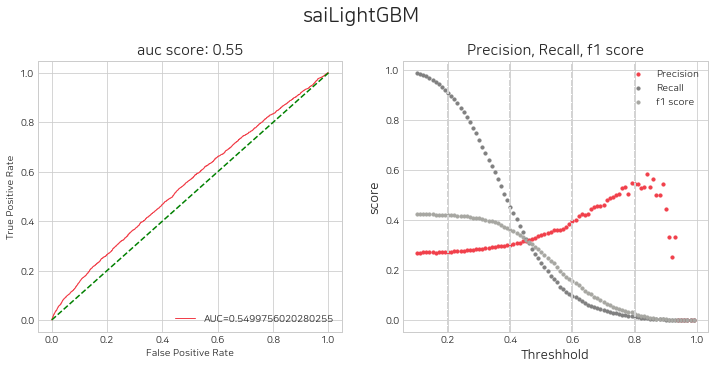

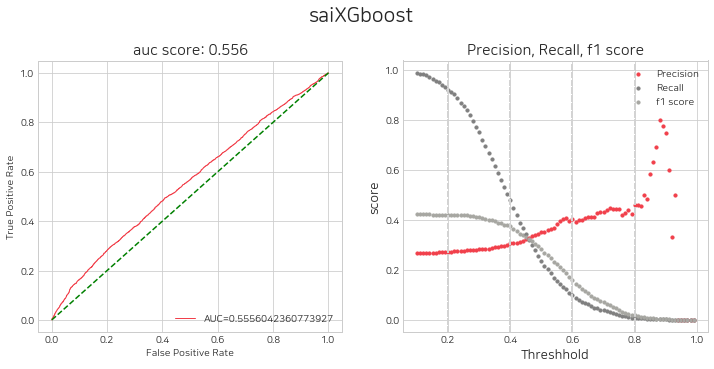

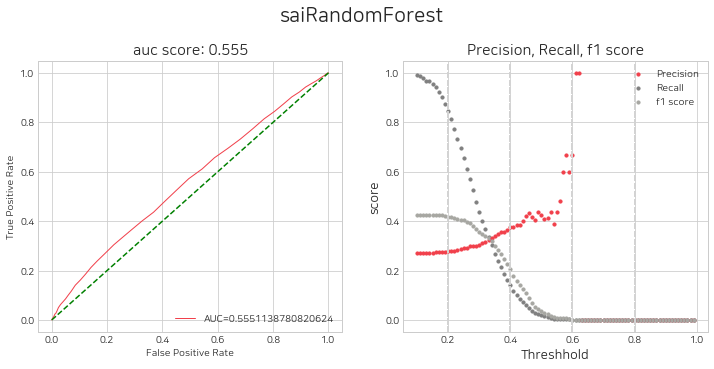

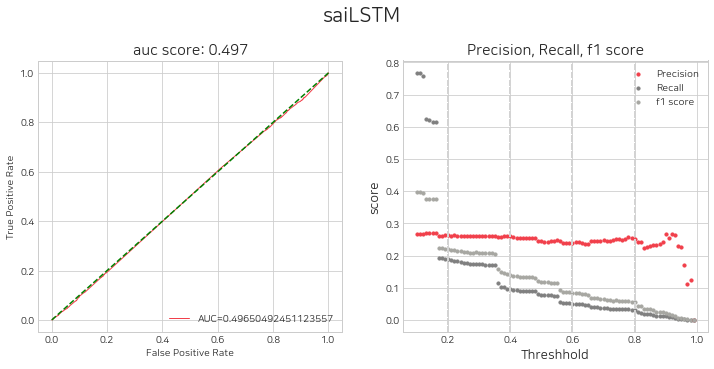

In [16]:
sai.get_eval_by_threshold(lst_trader)

#### threshold settings
View the visualization of the metrics above and set thresholds in the trader.

Error: local variable 'threshold' referenced before assignment
380/380 [==============================] - 2s 4ms/step


<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

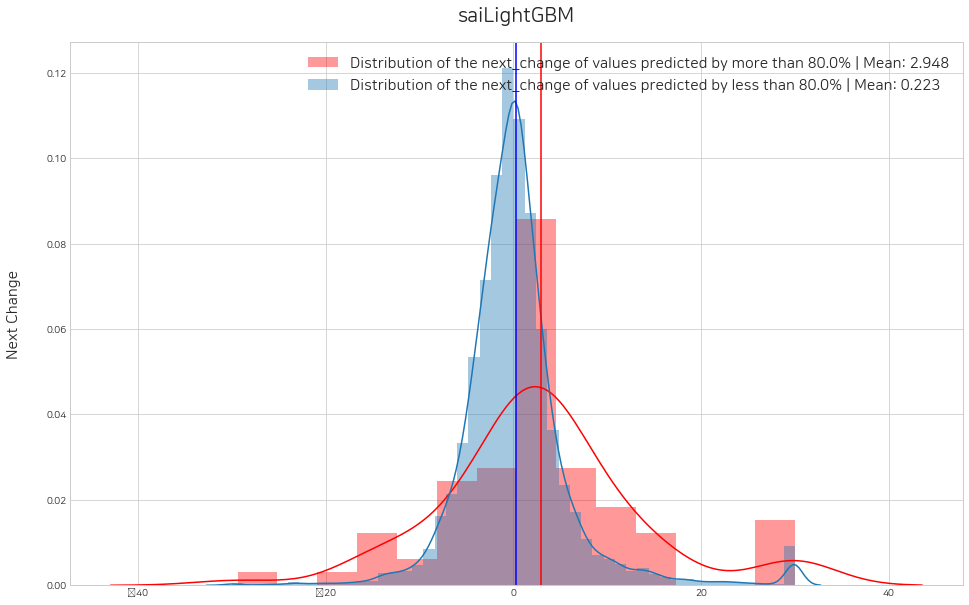

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

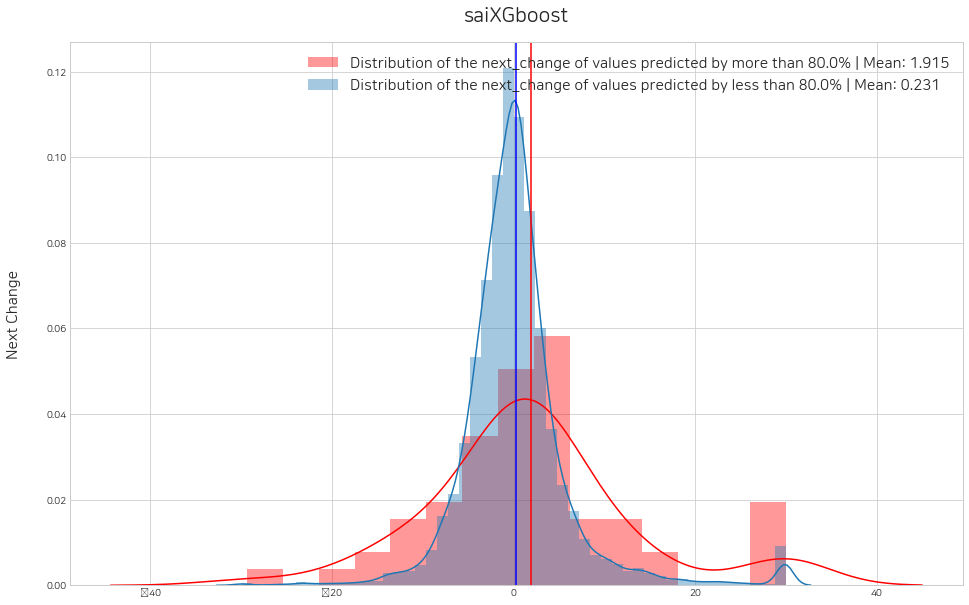

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

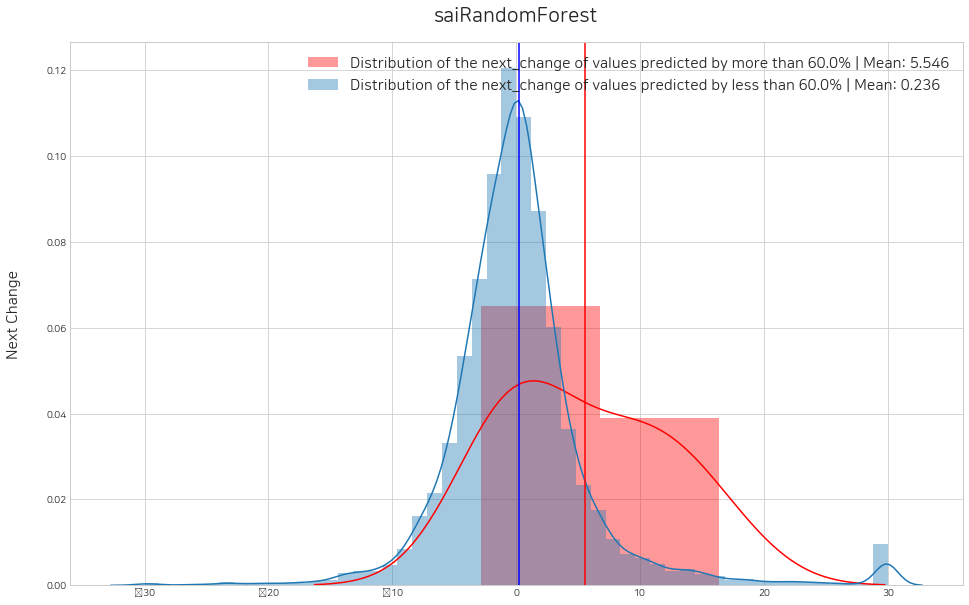

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

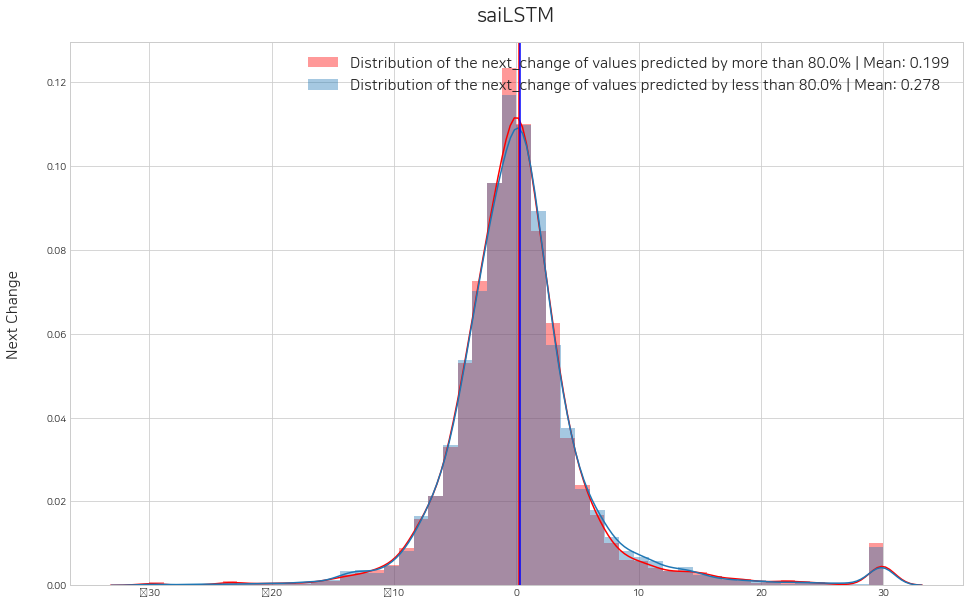

In [16]:
sai.set_threshold(lst_trader, lst_threshold=[0.8, 0.8, 0.6, 0.8], histogram=True)

# 4. Back-Testing

### 1) Making a sales log
For each trader, make a buying and selling record for all dates.

In [17]:
df_signal_all = sai.decision(lst_trader, dtype='test')
df_signal_all

217159it [00:06, 36183.33it/s]
217159it [00:05, 36418.57it/s]


== saiLightGBM completed ==


217159it [00:06, 35330.36it/s]
217159it [00:06, 35767.62it/s]


== saiXGboost completed ==


217159it [00:06, 35462.79it/s]
217159it [00:06, 35646.76it/s]


== saiRandomForest completed ==
6787/6787 [==============================] - 30s 4ms/step


217159it [00:05, 37334.97it/s]
217159it [00:05, 37169.70it/s]


== saiLSTM completed ==


,Trader_id,Date,Code,+(buy)/-(sell),Amount,Close
0,saiLightGBM,2021-01-04,000020,+,0.0,19100.0
1,saiLightGBM,2021-01-05,000020,+,0.0,19400.0
2,saiLightGBM,2021-01-06,000020,+,0.0,19700.0
3,saiLightGBM,2021-01-07,000020,+,0.0,19700.0
4,saiLightGBM,2021-01-08,000020,+,0.0,19100.0
...,...,...,...,...,...,...
217154,saiLSTM,2021-12-24,009900,-,1.0,30600.0
217155,saiLSTM,2021-12-27,009900,-,1.0,29900.0
217156,saiLSTM,2021-12-28,009900,-,1.0,29400.0
217157,saiLSTM,2021-12-29,009900,-,1.0,29850.0


### 2) Simulation: Calculate the yield
Calculate the yield for each trader based on the trading log above.


In [18]:
df_history_all = sai.simulation(df_signal_all, init_budget=10000000, init_stock={}, fee=0.01)
df_history_all

100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 247/248 [00:07<00:00, 33.88it/s]


== saiLSTM completed ==


100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 247/248 [00:07<00:00, 33.80it/s]


== saiLightGBM completed ==


100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 247/248 [00:07<00:00, 33.88it/s]


== saiRandomForest completed ==


100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 247/248 [00:07<00:00, 33.95it/s]

== saiXGboost completed ==


,Trader_id,Sell_date,Budget,Yield,Stock
0,saiLSTM,2021-01-04,10000000,0.000000,{}
1,saiLSTM,2021-01-05,10042066,0.420662,"{'000100': 3, '000660': 2, '001120': 10, '0013..."
2,saiLSTM,2021-01-06,9793093,-2.069066,"{'000120': 1, '001250': 154, '001430': 27, '00..."
3,saiLSTM,2021-01-07,9830300,-1.696992,"{'000220': 59, '001200': 107, '001250': 205, '..."
4,saiLSTM,2021-01-08,9808160,-1.918394,"{'000540': 105, '001200': 67, '001380': 131, '..."
...,...,...,...,...,...
243,saiXGboost,2021-12-24,6110500,-38.894995,{'025620': 315}
244,saiXGboost,2021-12-27,6110500,-38.894995,{}
245,saiXGboost,2021-12-28,6110500,-38.894995,{}
246,saiXGboost,2021-12-29,6110500,-38.894995,{}


### 3) Leader Board
Sorts the trader's yield results in the highest order and outputs them to the data frame.

In [19]:
sai.leaderboard(df_history_all)

,Trader_id,Yield
0,saiLightGBM,44.423725
1,saiRandomForest,29.597223
2,saiXGboost,-38.894995
3,saiLSTM,-96.950032


### 4) Visualize Results
View the yield visualization for all dates by trader.

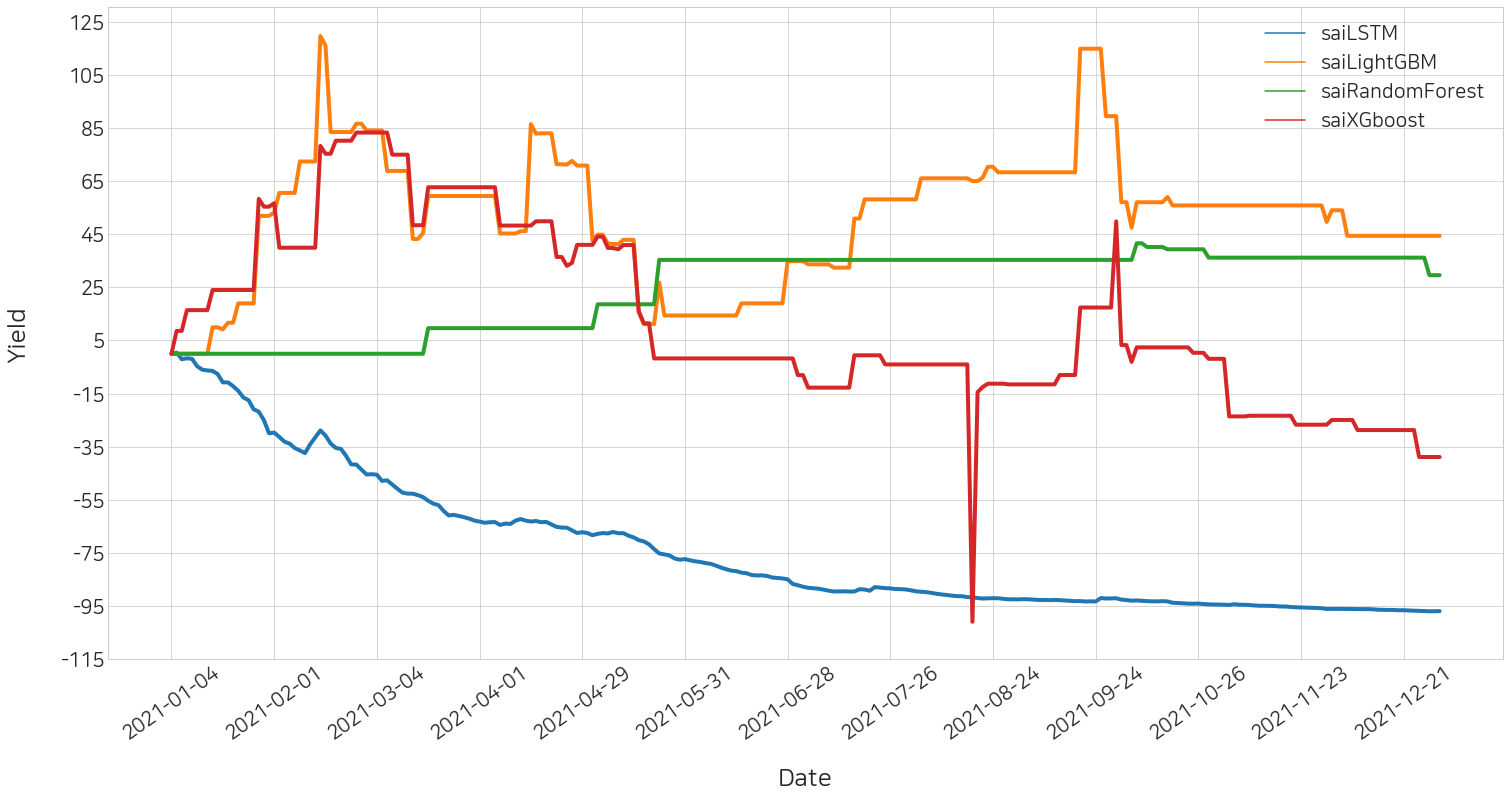

In [20]:
sai.yield_plot(df_history_all)

The results are as shown in the graph above. Among the four traders, the saiLightGBM trader performed best in terms of returns.